In [1]:
import numpy as np
from PyMPDATA import (Solver, Stepper, Options, ScalarField, VectorField,
                      ExtrapolatedBoundaryCondition, ConstantBoundaryCondition)
from PyMPDATA_examples.Shipway_and_Hill_2012 import Settings, Formulae, si, arakawa_c, const, plot, convert_to, DropletActivation
from PyMPDATA.arakawa_c.enumerations import ARG_DATA_INNER, ARG_DATA, INNER, OUTER, ONE_FOR_STAGGERED_GRID
from matplotlib import pylab
from PyMPDATA_examples.utils.show_plot import show_plot
import numba
import matplotlib

In [2]:
# note: 1=bulk
NRS=(30,)
R_MIN = 1 * si.um
R_MAX = 21* si.um

VERTVELO = 2.5*si.m/si.s
N_CCN_HALO = 500/si.mg
T_MAX=15*si.minutes
P0 = 1007*si.hPa

DT=2/3*si.s
DZ=100*si.m

OPTIONS = {
    Options(n_iters=3, flux_corrected_transport=True),
    Options(n_iters=2, flux_corrected_transport=True),
    Options(n_iters=1),
}

In [3]:
def repeat_in_r(vec, nr):
    return np.repeat(vec.reshape(-1,1), nr, axis=1).squeeze()

def label(options, nr):
    return f"nr={nr}_opt={options}"

In [4]:
class MPDATA:
    def __init__(self, nz, dt, qv_of_zZ_at_t0, g_factor_of_zZ, nr, options):
        self.t = 0
        self.dt = dt
        self.fields = ('qv', 'ql')

        self.options = options
                
        self._solvers = {}
        for k in self.fields:
            grid = (nz, nr) if nr>1 and k =='ql' else (nz,)
            
            bcs_extrapol=tuple(
                ExtrapolatedBoundaryCondition(dim=d)
                for d in ((OUTER, INNER) if k == 'ql' and nr > 1 else (INNER,))
            )
            bcs_zero=tuple(
                ExtrapolatedBoundaryCondition(dim=d)
                for d in ((OUTER, INNER) if k == 'ql' and nr > 1 else (INNER,))
            )
            
            stepper = Stepper(options=self.options, grid=grid, non_unit_g_factor=True)

            data = g_factor_of_zZ(arakawa_c.z_scalar_coord(grid)) 
            if nr > 1 and k == 'ql':
                data = repeat_in_r(data, nr)
            g_factor = ScalarField(
                data=data,
                halo=self.options.n_halo,
                boundary_conditions=bcs_extrapol
            )
            
            if nr == 1 or k == 'qv':
                data = (np.zeros(nz+1),)
            else:
                data = (np.zeros((nz+1, nr)), np.zeros((nz, nr+1)))
            advector = VectorField(
                data=data, 
                halo=self.options.n_halo,
                boundary_conditions=bcs_zero
            )
            if k == 'qv':
                data = qv_of_zZ_at_t0(arakawa_c.z_scalar_coord(grid))
                bcs = (ConstantBoundaryCondition(value = data[0]),)
            else:
                data = np.zeros(grid)
                if nr == 1:
                    bcs = (ConstantBoundaryCondition(value=0),)
                else:
                    bcs = (
                        ConstantBoundaryCondition(value=0), 
                        DropletActivation(N_CCN_HALO, settings.dr, settings.dz)
                    )
            advectee = ScalarField(
                data=data,
                halo=self.options.n_halo,
                boundary_conditions=bcs
            )
            self._solvers[k] = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor)
            
    def __getitem__(self, k):
        return self._solvers[k]

Simulating using nr=30 and options={'n_iters': 1, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': False, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


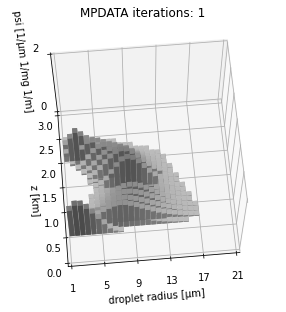

HTML(value="<a href='./fig_3d_n_iters=1.pdf' target='_blank'>./fig_3d_n_iters=1.pdf</a><br>")

Simulating using nr=30 and options={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


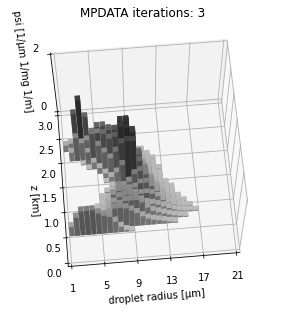

HTML(value="<a href='./fig_3d_n_iters=3.pdf' target='_blank'>./fig_3d_n_iters=3.pdf</a><br>")

Simulating using nr=30 and options={'n_iters': 2, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


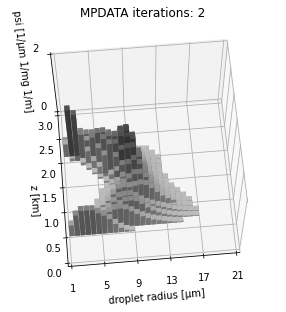

HTML(value="<a href='./fig_3d_n_iters=2.pdf' target='_blank'>./fig_3d_n_iters=2.pdf</a><br>")

In [18]:
outputs = {}
for options in OPTIONS:
    for nr in NRS:
        print(f"Simulating using nr={nr} and options={options}")
        
        settings = Settings(w_1=VERTVELO, nr=nr, dt=DT, dz=DZ, t_max=T_MAX, r_min=R_MIN, r_max=R_MAX, p0=P0)
        
        mpdata = MPDATA(
            nr=nr,
            nz=settings.nz, 
            dt=settings.dt, 
            qv_of_zZ_at_t0 = lambda zZ: settings.qv(zZ*settings.dz),
            g_factor_of_zZ = lambda zZ: settings.rhod(zZ*settings.dz), # TODO #239 spectral coord
            options=options
        )

        output = {k: np.zeros((settings.nz, settings.nt+1)) for k in ('qv', 'S', 'ql', 'act_frac', 'reldisp')}

        halo = mpdata.options.n_halo
        dpsi_shape = mpdata['ql'].advectee.get().shape    
                        
        @numba.experimental.jitclass([('dpsi_cond', numba.float64[:,:])])
        class PostIter:
            def __init__(self):
                self.dpsi_cond = np.zeros(dpsi_shape)

            def __call__(self, flux, g_factor, t, it):
                if it == 0:
                    self.dpsi_cond[:] = 0
                flux_wo_halo = flux[ARG_DATA_INNER][halo:-halo, halo-1:halo-1 + nr+ONE_FOR_STAGGERED_GRID]
                self.dpsi_cond[:] -= (
                    (flux_wo_halo[:,1:] - flux_wo_halo[:,:-1]) 
                    / 
                    g_factor[ARG_DATA][halo:-halo, halo:-halo]
                )
        post_iter = PostIter() if nr > 1 else None
            
        assert 't' not in output and 'z' not in output
        output['t'] = np.linspace(0, settings.nt*settings.dt, settings.nt+1, endpoint=True)
        output['z'] = np.linspace(settings.dz/2, (settings.nz-1/2)*settings.dz, settings.nz, endpoint=True)
        output['qv'][:,0] = mpdata['qv'].advectee.get()

        prof = {}
        prof['rhod'] = settings.rhod(output['z'])
        prof['T'] = Formulae.T(prof['rhod'], settings.thd(output['z']))
        prof['p'] = Formulae.p(prof['rhod'], prof['T'], output['qv'][:,0])
        prof['pvs'] = Formulae.pvs_Celsius(prof['T']-const.T0)

        Gvec = settings.rhod(settings.z_vec)
        Gscl = prof['rhod']

        for t in range(settings.nt):
            C = settings.w((t+.5) * settings.dt) * settings.dt / settings.dz
            advector_0 = Gvec * C
            mpdata['qv'].advector.get_component(0)[:] = advector_0
            mpdata['qv'].advance(1)

            qv = mpdata['qv'].advectee.get()
            RH = Formulae.pv(prof['p'], qv) / prof['pvs']

            if nr==1:
                mpdata['ql'].advector.get_component(0)[:] = advector_0
            else:
                mpdata['ql'].advector.get_component(0)[:, :] = np.repeat(advector_0.reshape(1,-1).T, nr, axis=1)
                mpdata['ql'].advector.get_component(1)[:, :] = (
                    # scalar
                    settings.ksi_1 * settings.dt / settings.dr # m2/s * s / m
                    # column
                    * np.repeat((Gscl * (np.maximum(1, RH)-1)).reshape(1,-1).T, nr+1, axis=1) # kg/m3
                    # spectrum
                    / np.repeat(settings.bin_boundaries.reshape(1,-1), settings.nz, axis=0) # m-1       
                )
                GC_max = [
                    np.amax(mpdata['ql'].advector.get_component(d)[:,0]) for d in range(2)
                ]
                if GC_max[1] > 1:
                    raise Exception(f"max(GC) = {GC_max[1]} > 1")
            mpdata['ql'].advance(1, post_iter=post_iter)

            if nr==1:
                ql = mpdata['ql'].advectee.get()
                # note: this is possibly too inaccurate, would better iterate (but bulk is not our aim here)
                # note: also, something along these lines could be added: assert not np.logical_and(S<1, ql>0).any()
                dql = np.maximum(0, qv * (1 - 1/RH))
                ql += dql
            else:
                psi = mpdata['ql'].advectee.get()
                
                if GC_max[1] > 0 and t % (settings.t_1/DT) == 0:
                    pylab.figure(figsize=(10,5))
                    ax = pylab.subplot(projection='3d')
                    ax.view_init(65, 85)

                    cmap = matplotlib.cm.get_cmap('gray_r')
                    max_height = 2 / si.mg / si.um  
                    min_height = 0

                    dz = np.rot90(psi, 2).flatten()
                    rgba = [cmap((k - min_height) / (1.5*max_height)) for k in dz]
                    dz[dz < .01 * max_height] = np.nan
                    factor = .9
                    ax.bar3d(
                        *[arr.flatten() for arr in np.meshgrid(
                            (settings.bin_boundaries[-2::-1]+settings.dr*(1-factor)/2) / si.um,
                            (np.arange(settings.nz-1, -1, -1)+(1-factor)/2) * settings.dz / si.km
                        )],
                        z=0,
                        dx= factor * settings.dr / si.um,
                        dy= factor * settings.dz / si.km,
                        dz=dz / (1 / si.mg / si.um),
                        shade=True,
                        color=rgba,
                        lightsource=matplotlib.colors.LightSource(azdeg=-64, altdeg=15)
                    )
                    ax.set_title(f"MPDATA iterations: {options.n_iters}")
                    ax.set_xlabel("droplet radius [μm]")
                    ax.set_ylabel("z [km]")
                    ax.set_zlabel("psi [1/μm 1/mg 1/m]")
                    ax.set_zlim(0, max_height / (1 / si.mg / si.um))
                    ax.set_zticks([0, max_height / (1 / si.mg / si.um)])
                    ax.set_ylim(settings.z_max / si.km, 0)
                    ax.set_xlim(R_MAX / si.um, R_MIN / si.um)
                    nticks = 5
                    ax.set_xticks((R_MIN + np.arange(nticks+1) * (R_MAX - R_MIN) / nticks) / si.um)
                    show_plot(f'fig_3d_n_iters={options.n_iters}.pdf')
                    
                # advection/conservation of n/V, but G_factor=G_z*G_r=rho(z)*1, so psi=n/V/rho

                def moment(data, l):
                    return np.sum(np.dot(data, settings.dr_power[l+1]/(l+1)), axis=1)*settings.dz
                
                dql_cond = 4/3*np.pi*const.rho_l*moment(post_iter.dpsi_cond, 3)   
                ql = 4/3*np.pi*const.rho_l*moment(psi, 3)

                N_tot = moment(psi, 0)
                output['act_frac'][:,t+1] = N_tot / N_CCN_HALO
                
                with np.errstate(divide='ignore', invalid='ignore'):
                    mom1 = moment(psi, 1) / N_tot
                    mom2 = moment(psi, 2) / N_tot
                    reldisp = np.sqrt(mom2 - mom1**2) / mom1
                reldisp[N_tot/N_CCN_HALO < .05] = np.nan
                output['reldisp'][:, t+1] = reldisp
                
            qv -= dql_cond

            output['ql'][:,t+1] = ql    
            output['qv'][:,t+1] = qv
            output['S'][:,t+1] = RH - 1
            
        outputs[label(options, nr)] = output

Plotting results for nr 30:
nr=30_opt={'n_iters': 1, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': False, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


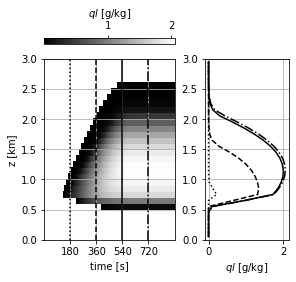

HTML(value="<a href='./fig_prof_ql_n_iters=1.pdf' target='_blank'>./fig_prof_ql_n_iters=1.pdf</a><br>")

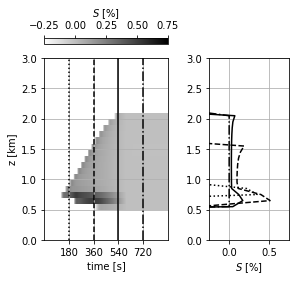

HTML(value="<a href='./fig_prof_S_n_iters=1.pdf' target='_blank'>./fig_prof_S_n_iters=1.pdf</a><br>")

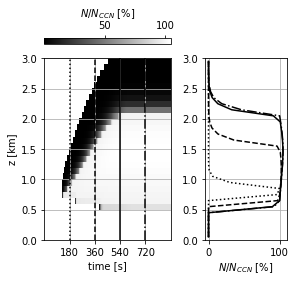

HTML(value="<a href='./tmpmqlhmfzl.pdf' target='_blank'>./tmpmqlhmfzl.pdf</a><br>")

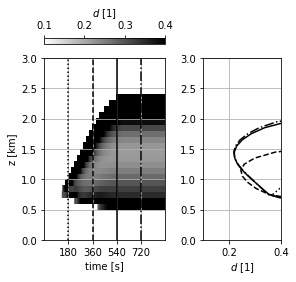

HTML(value="<a href='./fig_prof_d_n_iters=1.pdf' target='_blank'>./fig_prof_d_n_iters=1.pdf</a><br>")

nr=30_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


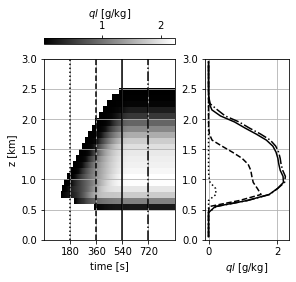

HTML(value="<a href='./fig_prof_ql_n_iters=3.pdf' target='_blank'>./fig_prof_ql_n_iters=3.pdf</a><br>")

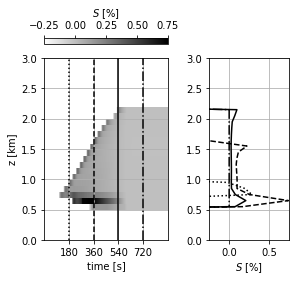

HTML(value="<a href='./fig_prof_S_n_iters=3.pdf' target='_blank'>./fig_prof_S_n_iters=3.pdf</a><br>")

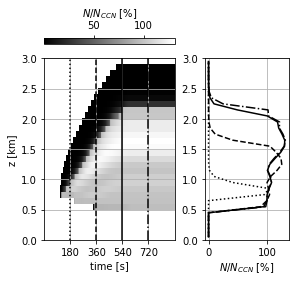

HTML(value="<a href='./tmpfx5eq2gr.pdf' target='_blank'>./tmpfx5eq2gr.pdf</a><br>")

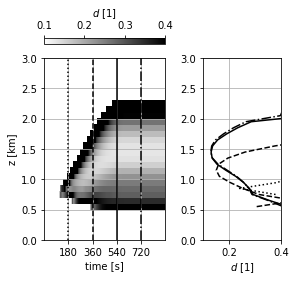

HTML(value="<a href='./fig_prof_d_n_iters=3.pdf' target='_blank'>./fig_prof_d_n_iters=3.pdf</a><br>")

nr=30_opt={'n_iters': 2, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


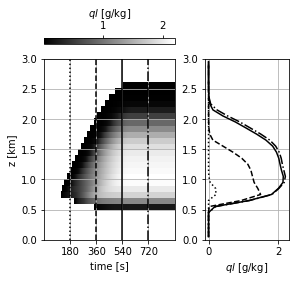

HTML(value="<a href='./fig_prof_ql_n_iters=2.pdf' target='_blank'>./fig_prof_ql_n_iters=2.pdf</a><br>")

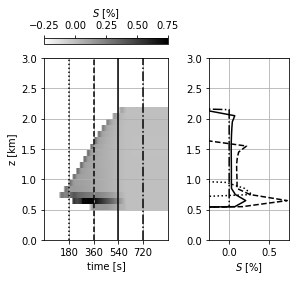

HTML(value="<a href='./fig_prof_S_n_iters=2.pdf' target='_blank'>./fig_prof_S_n_iters=2.pdf</a><br>")

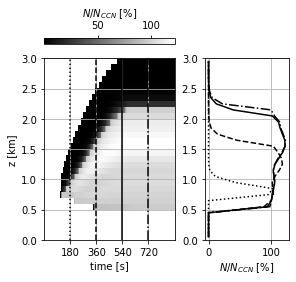

HTML(value="<a href='./tmpxjvszk1r.pdf' target='_blank'>./tmpxjvszk1r.pdf</a><br>")

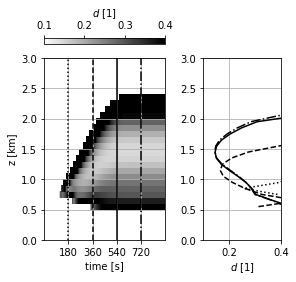

HTML(value="<a href='./fig_prof_d_n_iters=2.pdf' target='_blank'>./fig_prof_d_n_iters=2.pdf</a><br>")

In [8]:
cmap='gray'
rasterized=True
figsize=(4,4)
for nr in NRS:
    print("Plotting results for nr {}:".format(nr))
    for options in OPTIONS:
        key = label(options, nr)
        print(key)
#         plot(var='qv', mult=1e3, label='$q_v$ [g/kg]', output=outputs[f'{key}'], cmap=cmap, threshold=1e-3)
#         show_plot()
        plot(var='ql', mult=1e3, label='$ql$ [g/kg]', output=outputs[f'{key}'], cmap=cmap, threshold=1e-3, figsize=figsize)
        show_plot(f'fig_prof_ql_n_iters={options.n_iters}.pdf')
        plot(var='S', mult=1e2, label='$S$ [%]', range=(-.25, .75), output=outputs[f'{key}'], cmap=cmap+'_r', figsize=figsize)
        show_plot(f'fig_prof_S_n_iters={options.n_iters}.pdf')
        plot(var='act_frac', mult=1e2, label='$N/N_{CCN}$ [%]', output=outputs[f'{key}'], cmap=cmap, threshold=1e-3, figsize=figsize)
        show_plot()
        plot(var='reldisp', mult=1, label='$d$ [1]', range=(0.1, 0.4), output=outputs[f'{key}'], cmap=cmap+'_r', figsize=figsize)
        show_plot(f'fig_prof_d_n_iters={options.n_iters}.pdf')